In [ ]:
import shapiq

print(f"shapiq version: {shapiq.__version__}")

# ShapIQ Storing Interactions
In `shapiq` we seek to only compute Shapley Values but also higher orders, so called Shapley Interactions.
All our `shapiq.Explainers` and `shapiq.Approximators` work with so called `shapiq.InteractionValues`.
The idea is to work with computed interactions in the most intuitive way.

## Initializing InteractionValues

Let us now first showcase a simple example of an `InteractionValues` object

In [13]:
from shapiq import InteractionValues

raw_scores = {
    (0,): 1.0,
    (1,): 1.0,
    (2,): 1.0,
}
interaction_values_sv = InteractionValues(
    values=raw_scores, index="SV", max_order=1, n_players=3, min_order=1
)
print(interaction_values_sv)

InteractionValues(
    index=SV, max_order=1, min_order=1, estimated=True, estimation_budget=None,
    n_players=3, baseline_value=0.0,
    Top 10 interactions:
        (0,): 1.0
        (1,): 1.0
        (2,): 1.0
)


Here we have constructed a simple `InteractionValues` object, with three players.
It contains the Shapley Values of the players, indicated by `index="SV"`.
We also define which magnitude of interactions we have stored, by defining `min_order=1` and `max_order = 1`.
All currently supported indices are

In [14]:
from shapiq.game_theory.indices import AllIndices

AllIndices

{'BGV',
 'BII',
 'BV',
 'CHGV',
 'CHII',
 'Co-Moebius',
 'EC',
 'EGV',
 'ELC',
 'FBII',
 'FSII',
 'IGV',
 'JointSV',
 'Moebius',
 'SGV',
 'SII',
 'STII',
 'SV',
 'k-SII',
 'kADD-SHAP'}

If we now would consider not only Shapley Values but also Shapley Interactions of order two, then the corresponding `InteractionValues` would be

In [15]:
from shapiq import InteractionValues

raw_scores = {
    (): 0,
    (0,): 1,
    (1,): 1,
    (2,): 1,
    (0, 1): 0.5,
    (0, 2): 0.5,
    (1, 2): 0.5,
}
interaction_values_sii = InteractionValues(
    values=raw_scores, index="SII", max_order=2, n_players=3, min_order=0
)
print(interaction_values_sii)

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=True, estimation_budget=None,
    n_players=3, baseline_value=0.0,
    Top 10 interactions:
        (0,): 1.0
        (1,): 1.0
        (2,): 1.0
        (0, 1): 0.5
        (0, 2): 0.5
        (1, 2): 0.5
        (): 0.0
)


We extended `raw_scores` to also contain the baseline value (zero order effect), which is indicated by `min_order=0`. <br>
**Note**: There also exists another variant of initializing `InteractionValues` by setting `values` equal to a `np.ndarray`.
The shortcoming is that there must be some mapping, assigning each interaction its respective entry in the `np.ndarray`.
It can be given at initialization as `interaction_lookup`.
If not given, `shapiq` assumes the `np.ndarray`to follow the ordering: 
- The overall structure is assumed to be Baseline -> First Order -> Second Order ..
- First Order: Player 0 -> Player 1 -> ... -> Player n. 
- Second Order: Player 0 x Player 1 -> Player 0 x Player 2 -> ... Player 0 x Player n -> Player 1 x Player 2 -> ...
- Higher orders: Follow a similar scheme.
Therefore we argue to directly give `values` a dictionary mapping coalitions to Shapley Values/Interactions.

## Manipulating InteractionValues

For manipulating with `InteractionValues` we support *addition*,*scalar multiplication* and *subtraction*.

In [16]:
scalar_interaction_values_sv = interaction_values_sv + 2  # Increase all values by 2
scalar_interaction_values_sv *= 2  # Multiply all values by 2
scalar_interaction_values_sv -= 2  # Decrease all values by 2

Between two and more `InteractionValues` we support *addition*,*subtraction* and *aggregation*. <br>
**Note**: This requires both to have the same `.index`!

In [ ]:
interaction_values_sii2 = InteractionValues(
    values=raw_scores, index="SII", max_order=2, n_players=3, min_order=0
)
added_interaction_values_sii = (
    interaction_values_sii + interaction_values_sii2
)  # Add two InteractionValues
subtracted_interaction_values_sii = (
    interaction_values_sii - interaction_values_sii2
)  # Subtract two InteractionValues
aggregated_interaction_values_sii = interaction_values_sii.aggregate(
    [interaction_values_sii2],
    aggregation="mean",  # For more options see the documentation
)  # Aggregate two InteractionValues

If we are interested in only a specific order of effects given an `InteractionValues` object, we use `.get_n_order()` or `.get_n_order_values()`.
A `InteractionValues` object only containing the effect of a specific order is obtained by `.get_n_order()`.
In contrast a (hyper-)tensor is constructed when calling `.get_n_order_values`, reducing to matrix for second order and to a vector for first order effects.
For the (hyper-)tensor $M$ a entry $M_A = y$ is the interaction value of coalition $A$. <br>
**Notice**: $M_{i,j} = M_{j,i}$.

In [ ]:
print(interaction_values_sii.get_n_order(2))  # Get values for order 2
print(interaction_values_sii.get_n_order_values(2))  # Get values for order 2 as matrix x

InteractionValues(
    index=SII, max_order=2, min_order=2, estimated=True, estimation_budget=None,
    n_players=3, baseline_value=0.0,
    Top 10 interactions:
        (0, 1): 0.5
        (0, 2): 0.5
        (1, 2): 0.5
)
[[0.  0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0. ]]


A reduced `InteractionValues` object, restricted only to a subset of players, can be obtained with `.get_subset()`.

In [19]:
print(interaction_values_sii.get_subset([0, 2]))  # Get InteractionValues for players 0 and 2

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=True, estimation_budget=None,
    n_players=1, baseline_value=0.0,
    Top 10 interactions:
        (0,): 1.0
        (2,): 1.0
        (0, 2): 0.5
        (): 0.0
)


In the case a `InteractionValues` object contains a lot of small values, it can be filtered by `.sparsify()`.
The values to remove is controlled by the `threshold=1e-3` parameter.

In [20]:
noisy_scores = {
    (0,): 1.0,
    (1,): 1.0,
    (2,): 1.0,
    (0, 1): 1e-5,
    (0, 2): 1e-3,
    (1, 2): -1e-5,
}
interaction_values_sii_noisy = InteractionValues(
    values=noisy_scores, index="SII", max_order=2, n_players=3, min_order=0
)
interaction_values_sii_noisy.sparsify(threshold=1e-3)
print(interaction_values_sii_noisy.interactions)

{(0,): 1.0, (1,): 1.0, (2,): 1.0, (0, 2): 0.001}


**Notice**: 
- The operation is **in-place**!
- Values `< threshold` are removed and not `<= threshold`

## Visualizing Interaction Values
After designing the `InteractionValues` object, we now consider its visualization.

We support visualizations known from `shap`: `.plot_force()`, `.plot_waterfall()`and `.plot_stacked_bar()`.
Additionally custom visualizations such as `.plot_network()`, `.plot_upset()` and `.plot_si_graph()` are available.

For a detailed explanations of those we refer to the dedicated notebook on visualizations.

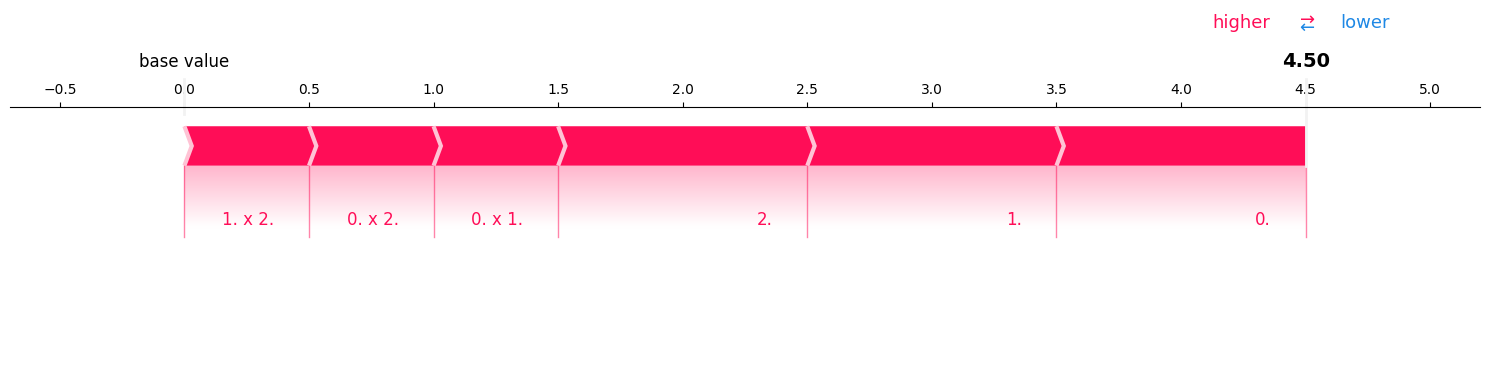

In [25]:
interaction_values_sii.plot_force()

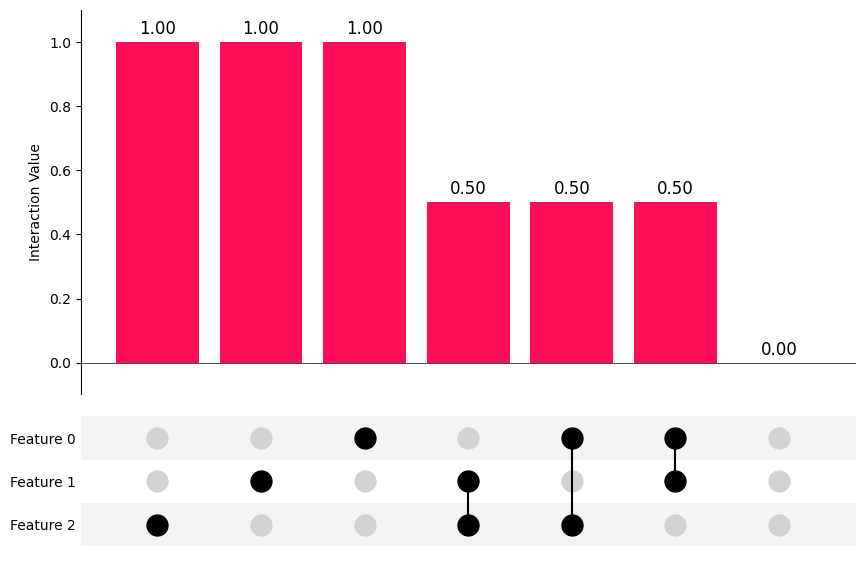

In [22]:
interaction_values_sii.plot_upset()

## Saving and Loading InteractionValues
At the end we might want to save our `InteractionValues` object.
We use `.json` to `.save()` our interactions.

In [23]:
import pathlib

path = pathlib.Path("interaction_values_sii.json")  # Define the path to save the InteractionValues
interaction_values_sii.save(path)  # Save InteractionValues to a file

For `shapiq.version < 1.4.0` saving were done as `.npz` or `.pickle` files.
This usage is deprecated starting with version `1.4.0`.
A script for conversion to `.json` is available under `shapiq/scripts/convert_to_new_save_format.py`.

Loading is done by using the *classmethod* `.load()`

In [24]:
loaded_interaction_values_sii = InteractionValues.load(path)  # Load InteractionValues from a file
print(loaded_interaction_values_sii)  # Verify that the loaded InteractionValues match the

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=True, estimation_budget=None,
    n_players=3, baseline_value=0.0,
    Top 10 interactions:
        (0,): 1.0
        (1,): 1.0
        (2,): 1.0
        (0, 1): 0.5
        (0, 2): 0.5
        (1, 2): 0.5
        (): 0.0
)
